# making movies of the Sun

The Helioseismic and Magnetic Imager (HMI) on the Solar Dynamics Observatory takes continuum intensity, doppler velocity, and magnetic field maps of the solar surface. Here, we make a movie of the radial component of the vector magnetic field using a data product called [HMI Space-weather Active Region Patches](http://link.springer.com/article/10.1007%2Fs11207-014-0529-3) or SHARPs. SHARPs contain patches of HMI data that encapsulate automatically-detected active regions. These data are useful because we don't have to query the entire full-disk HMI image (each of which are 4096 x 4096 pixels) to study one active region.  

We can make movies in two different ways: 

- Use JSOC Exportdata to build a movie directly (but you are limited to its formats and colortables); see the ipython notebook within this same directory called `plot_swx_d3.ipynb` for an example.
- Make a movie from image data to create a customized movie of any size, colortable, or format. An example of this process is outlined below.

First, we import some modules:

In [1]:
import json, urllib, numpy as np, matplotlib, matplotlib.pylab as plt
import matplotlib.animation as manimation
from astropy.io import fits
import matplotlib.animation as manimation
%matplotlib inline
%config InlineBackend.figure_format='retina'

We query the JSOC database, where all the SDO data are stored, using the JSON API to retrieve both keywords and the location of the SHARP image files. The [astropy](http://docs.astropy.org/en/stable/io/fits/index.html) library's  `fits.open()` call downloads the data. Here, we're querying for the $B_z$ component of the vector magnetic field (note the variable passed to the `Seg` keyword in the url below), although we can easily query for other data products (see table A.7 in [Bobra et al., 2014](http://link.springer.com/article/10.1007%2Fs11207-014-0529-3) for segment name information). <br>

Here are some keyword definitions:
* `xsize` and `ysize` give the x and y-dimensions of the image, respectively, in pixels,
* `NOAA_ARS` specifies the NOAA Active Region number that corresponds to the data, and
* `T_REC` specifies the time that the image was taken.

In [2]:
def get_the_data():
    url = "http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?ds=hmi.sharp_cea_720s[377][2011.02.15_02:00:00_TAI/4h]&op=rs_list&key=NOAA_ARS,T_REC&seg=Br"
    response = urllib.urlopen(url)
    data = json.loads(response.read())
    xsize = float(data['segments'][0]['dims'][0].rsplit('x', 1)[0])
    ysize = float(data['segments'][0]['dims'][0].rsplit('x', 1)[1])
    print "The image is ",xsize," by ",ysize,"."
    count = int(data['count'])
    NOAA_ARS = str(data['keywords'][0]['values'][0])
    bz = np.ndarray([ysize,xsize,count])
    t_rec = []
    for i in range(count):
        bz_fits = fits.open("http://jsoc.stanford.edu"+data['segments'][0]['values'][i])
        bz[:,:,i] = bz_fits[1].data
        t_rec.append(str(data['keywords'][1]['values'][i]))
    t_rec = np.array(t_rec)
    return bz, NOAA_ARS, t_rec, xsize, ysize, count

In [3]:
bz, NOAA_ARS, t_rec, xsize, ysize, count = get_the_data()

The image is  744.0  by  377.0 .


This is what the data look like, using the seismic color table (you can also use the [SunPy color tables](http://docs.sunpy.org/en/stable/_modules/sunpy/cm/cm.html) for SDO images). The red and blue colors indicate negative and positive polarities, respectively.

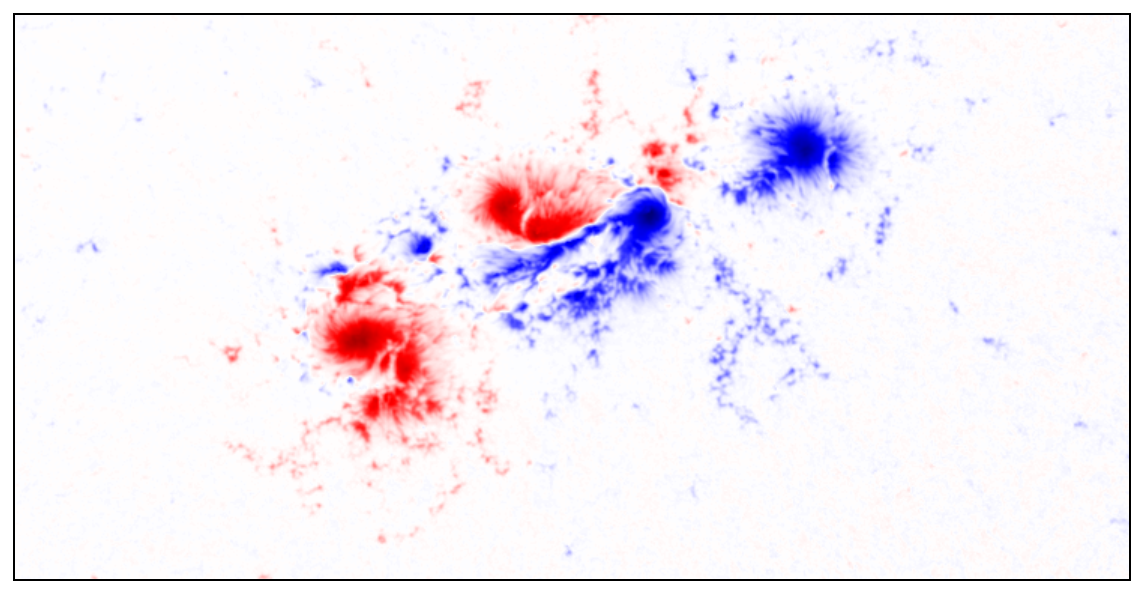

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
plt.imshow(bz[:,:,0],cmap='seismic_r',origin='lower',vmin=-3000,vmax=3000,extent=[0,xsize,0,ysize])
fig.set_size_inches(10,10)

Now we use the `matplotlib.animation.Animation()` class to simply cycle through our data cube, grab each image, and export an mp4 file!

The figure is the following size (in pixels): Figure(744x377)


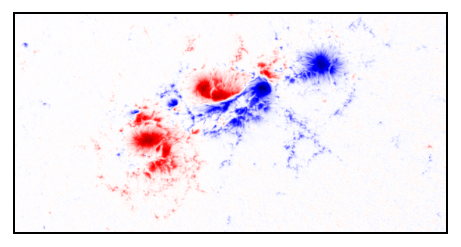

In [5]:
my_dpi=192 # dpi for retina display (detect monitor dpi automatically here: http://www.infobyip.com/detectmonitordpi.php)
fig = plt.figure(figsize=(xsize/my_dpi, ysize/my_dpi), dpi=my_dpi)
print "The figure is the following size (in pixels):",fig
ax = fig.add_subplot(1,1,1)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
savefigdict = {'bbox_inches' : 'tight'}

ims = []
for i in range(count):
    im = plt.imshow(bz[:,:,i],cmap='seismic_r',origin='lower',vmin=-3000,vmax=3000,extent=[0,xsize,0,ysize], interpolation=None, animated=True)
    ims.append([im])

ani = manimation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

Finally, you can save your movie with the following command: 

`ani.save(NOAA_ARS+'.mp4', savefig_kwargs=savefigdict, writer='ffmpeg_file', dpi=my_dpi)`